In [6]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np
import sys
from nibabel.testing import data_path
import nibabel as nib
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
import torchio
import torch
from torchvision import transforms
from monai.data import ITKReader, PILReader
from monai.transforms import LoadImage

import SimpleITK as sitk

sys.path.insert(0, '../../scripts/')
from helpers import miscellaneous as misc
CONFIG = misc.get_config()

def show_slices(img_data):
    paramtools = {
        'i': IntSlider(min=0, max=img_data.shape[0]-1, step=1),
        'j': IntSlider(min=0, max=img_data.shape[1]-1, step=1),
        'k': IntSlider(min=0, max=img_data.shape[2]-1, step=1),
    }
    
    @interact(**paramtools)
    def show_interactive(i, j, k):
        fig, axes = plt.subplots(1, 3, figsize=(25,25))
        axes[0].imshow(img_data[i,:,:].T, cmap="magma", origin="lower")
        axes[1].imshow(img_data[:,j,:].T, cmap="magma", origin="lower")
        axes[2].imshow(img_data[:,:,k].T, cmap="magma", origin="lower")

In [7]:
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"
img_dir = '../../' + CONFIG['FLATTENED_DATA_DIR']

img_ids = os.listdir(img_dir)
shapes = []

for id_ in img_ids:
    shapes.append(nib.load(img_dir + id_).shape)

In [8]:
shapes = np.array(shapes)
shapes

array([[256, 256, 166],
       [256, 256, 166],
       [256, 256, 166],
       ...,
       [192, 192, 160],
       [192, 192, 160],
       [192, 192, 160]])

All unique shapes of .nii files:

In [9]:
np.unique(shapes.view(np.dtype((np.void, shapes.dtype.itemsize * shapes.shape[1])))).view(shapes.dtype).reshape(-1, shapes.shape[1])

array([[256, 256, 124],
       [256, 256, 146],
       [256, 256, 150],
       [256, 256, 160],
       [256, 256, 161],
       [256, 256, 162],
       [256, 256, 166],
       [256, 256, 170],
       [256, 256, 180],
       [256, 256, 184],
       [192, 192, 144],
       [192, 192, 160],
       [192, 192, 176]])

In [20]:
bigger_image = nib.load(img_dir + img_ids[0])
smaller_image = nib.load(img_dir + img_ids[-1])

In [7]:
bigger_image_fdata = bigger_image.get_fdata()
#bigger_image_fdata = np.reshape(bigger_image_fdata, (bigger_image_fdata.shape[0], bigger_image_fdata.shape[1], bigger_image_fdata.shape[2]))
print('shape fdata: ', bigger_image_fdata.shape)
#print('shape image: ', bigger_image.shape)
show_slices(bigger_image_fdata)

shape fdata:  (256, 256, 166)


interactive(children=(IntSlider(value=0, description='i', max=255), IntSlider(value=0, description='j', max=25…

In [8]:
smaller_image_fdata = smaller_image.get_fdata()
#smaller_image_fdata = np.reshape(smaller_image_fdata, (smaller_image_fdata.shape[0], smaller_image_fdata.shape[1], smaller_image_fdata.shape[2]))
print('shape: ', smaller_image_fdata.shape)
show_slices(smaller_image_fdata)

shape:  (192, 192, 160)


interactive(children=(IntSlider(value=0, description='i', max=191), IntSlider(value=0, description='j', max=19…

In [21]:
print("bigger image header: ", bigger_image.header, "\n")
print("smaller image header: ", smaller_image.header)

bigger image header:  <class 'nibabel.nifti1.Nifti1Header'> object, endian='>'
sizeof_hdr      : 348
data_type       : b''
db_name         : b'002_S_0295'
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 256 256 166   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.        0.9475275 0.9375    1.2023071 1.        1.        1.
 1.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 2650
glmin           : 0
descrip         : b'MPR; GradWarp; B1 Correction; N3; Scaled_2'
aux_file        : b'none'
qform_code      : scanner
sform_code      : unknown
quatern_b       : 0.70710677
quatern_c       : -5.06476

Main differences here are:

pixdim:

- bigger image: [1.        0.9475275 0.9375    1.2023071 1.        1.        1. 1.       ]
- smaller image: [1.        1.2503338 1.2487837 1.1975172 1.        1.        1. 1.       ]

pixdim is the voxel size and time interval. from https://discovery.ucl.ac.uk/id/eprint/1495621/1/Li%20et%20al%20The%20first%20step%20for%20neuroimaging%20data%20analysis%20-%20DICOM%20to%20NIfTI%20conversion.pdf it "encodes the voxel size and time interval corresponding to the spatial and temporal
dimensions. The first value has a special purpose, which will be mentioned later. The units of voxel size
and time are coded in parameter “xyzt_units”, but most converters default to millimeters and seconds."

This means the different values show the different voxel sizes of different sized scans. The time dimension seems to be the same here.


glmax:

- bigger image: 2650
- smaller image: 1333

qoffset_x:

- bigger image: 98.3686
- smaller image: 101.50169

qoffset_y:

- bigger image: 159.448
- smaller image: 141.69492

qoffset_z: 

- bigger image: 96.7781
- smaller image: 124.067795

The difference between shape is actually conserved in the qoffset_x,y and z (Quaternion x,y,z shift). When looking at the 2D images, there is just a difference in the amount of skin and soft tissue around the skull. We hope to be able to strip that away using more preprocessing techniques. There is probably a similar amount of information about the brain but since the dimensions are different, one picture might look really narrow compared to another one.

Coronal planes with different dimensions:

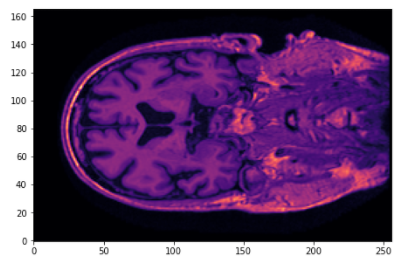
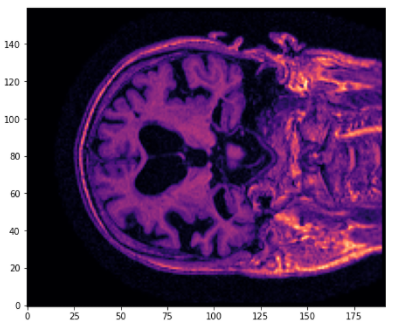


In [22]:
%%timeit

nib.load(img_dir + img_ids[12])

648 µs ± 17.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [23]:
%%timeit

torchio.ScalarImage(img_dir + img_ids[12])

58 µs ± 1.5 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [12]:
%%timeit

data, meta = LoadImage()(img_dir + img_ids[12])

46.2 ms ± 1.82 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
%%timeit

sitk_image = sitk.ReadImage(img_dir + img_ids[12])

88.4 ms ± 888 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Sample Resize to (150,150,100) using torchio:

In [37]:
img = torchio.ScalarImage(img_dir + img_ids[12])

preprocess = torchio.Compose([
            torchio.RescaleIntensity((-1, 1)),
            torchio.Resample((1,1,1)),
            torchio.EnsureShapeMultiple(8),
            torchio.Resize((150,150,100)),
            torchio.OneHot()
        ])

def show_slices(img_data):
    paramtools = {
        'i': IntSlider(min=0, max=img_data.shape[1]-1, step=1),
        'j': IntSlider(min=0, max=img_data.shape[2]-1, step=1),
        'k': IntSlider(min=0, max=img_data.shape[3]-1, step=1),
    }
    
    @interact(**paramtools)
    def show_interactive(i, j, k):
        fig, axes = plt.subplots(1, 3, figsize=(25,25))
        axes[0].imshow(img_data.data[0,i,:,:].T, cmap="magma", origin="lower")
        axes[1].imshow(img_data.data[0,:,j,:].T, cmap="magma", origin="lower")
        axes[2].imshow(img_data.data[0,:,:,k].T, cmap="magma", origin="lower")
        
img = preprocess(img)
print(img.data.shape)
show_slices(img)

torch.Size([1, 150, 150, 100])


interactive(children=(IntSlider(value=0, description='i', max=149), IntSlider(value=0, description='j', max=14…